## Preparing notebook

In [11]:
!pip install keras --upgrade
!pip install tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.1 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.4 MB/s eta 0:00:00:00:01

## Import libraries

In [12]:
import os
import keras
import numpy as np
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt

## Loading data

In [13]:
batch_size = 64
raw_train_ds = keras.utils.text_dataset_from_directory(
    '/kaggle/input/news-dataset/datas',
    label_mode='categorical',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337,
    shuffle=True
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    '/kaggle/input/news-dataset/datas',
    label_mode='categorical',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=1337,
    shuffle=True
)


print(f'Number of batches in raw_train_ds: {raw_train_ds.cardinality()}')
print(f'Number of batches in raw_val_ds: {raw_val_ds.cardinality()}')

Found 148586 files belonging to 4 classes.
Using 118869 files for training.
Found 148586 files belonging to 4 classes.
Using 29717 files for validation.
Number of batches in raw_train_ds: 1858
Number of batches in raw_val_ds: 465


In [14]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'hp unveils corporate copier streamlined multifunction device tech giant aim gain ground business copier'
[0. 0. 0. 1.]
b'falling bond yield worry 39 bond market federal reserve steadily increased interest rate past month investor pit pushed yield'
[1. 0. 0. 0.]
b'german auto worker mass strike nearly people germany took part protest u auto giant general motor 39 plan axe job european workforce'
[1. 0. 0. 0.]
b'international operator equity crowdfunding site beware sec may come adoption sec rule implement crowdfunding exemption operator crowdfunding platform tread extreme caution ensure compliance security law eureeca discovered hard way'
[1. 0. 0. 0.]
b'jyoti burn brightest end new delhi steel jyoti randhawa came fore indian golf star clinched volvo master asia title kota permai golf country club kuala lumpur sunday'
[0. 0. 1. 0.]


In [15]:
max_features = 20000
embedding_dim = 128
sequence_length = 80
num_classes = 4
num_heads = 8
units = 128
epochs = 5

vectorize_layer = keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [16]:
def vectorize_text(text, label):
    return vectorize_layer(text), label


train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)

## Create some models

In [17]:
metrics = ['accuracy',
           keras.metrics.F1Score(average='weighted')]

In [18]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')


x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)


x = layers.Conv1D(units, 7, padding='valid', activation='relu', strides=3, name='Conv1D1')(x)
x = layers.Conv1D(units, 7, padding='valid', activation='relu', strides=3, name='Conv1D2')(x)
x = layers.GlobalMaxPooling1D(name='GlobalMaxPooling1D')(x)


x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_1 = keras.Model(inputs, predictions)
model_1.summary()
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D1 (Conv1D)                │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D2 (Conv1D)                │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalMaxPooling1D              │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,806,660 (10.71 MB)

 Trainable params: 2,806,660 (10.71 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')
x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.LSTM(units, activation='relu', name='LSTM')(x)

x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_2 = keras.Model(inputs, predictions)
model_2.summary()
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,708,612 (10.33 MB)

 Trainable params: 2,708,612 (10.33 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')
x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM1'), name='Bidirectional1')(x)
x = layers.Bidirectional(layers.LSTM(units, name='LSTM2'), name='Bidirectional2')(x)

x = layers.Dense(units, activation='relu', name='Dense1')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_3 = keras.Model(inputs, predictions)
model_3.summary()
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional1 (Bidirectional)  │ (None, None, 256)      │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional2 (Bidirectional)  │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,250,820 (12.40 MB)

 Trainable params: 3,250,820 (12.40 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')

x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, name='Attention')(query=x, value=x)
x = layers.GRU(units, return_sequences=True, activation='tanh', name='GRU')(x)
x = layers.GlobalMaxPool1D(name='GlobalMaxPool1D')(x)

x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_4 = keras.Model(inputs, predictions)
model_4.summary()
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, None, 128) │  2,560,000 │ InputLayer[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout1 (Dropout)  │ (None, None, 128) │          0 │ Embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention           │ (None, None, 128) │    527,488 │ Dropout1[0][0],   │
│ (MultiHeadAttentio… │                   │            │ Dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU (GRU)           │ (None, None, 128) │     99,072 │ Attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPool1D     │ (None, 128)       │          0 │ GRU[0][0]         │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense (Dense)       │ (None, 128)       │     16,512 │ GlobalMaxPool1D[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout2 (Dropout)  │ (None, 128)       │          0 │ Dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 4)         │        516 │ Dropout2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,203,588 (12.22 MB)

 Trainable params: 3,203,588 (12.22 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')

x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, name='Attention')(query=x, value=x)

x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM1'), name='Bidirectional1')(x)
x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM2'), name='Bidirectional2')(x)
x = layers.GlobalAveragePooling1D(name='GlobalAveragePooling1D')(x)

x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_5 = keras.Model(inputs, predictions)
model_5.summary()
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, None, 128) │  2,560,000 │ InputLayer[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout1 (Dropout)  │ (None, None, 128) │          0 │ Embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention           │ (None, None, 128) │    527,488 │ Dropout1[0][0],   │
│ (MultiHeadAttentio… │                   │            │ Dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bidirectional1      │ (None, None, 256) │    263,168 │ Attention[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bidirectional2      │ (None, None, 256) │    394,240 │ Bidirectional1[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalAveragePooli… │ (None, 256)       │          0 │ Bidirectional2[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense (Dense)       │ (None, 128)       │     32,896 │ GlobalAveragePoo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout2 (Dropout)  │ (None, 128)       │          0 │ Dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 4)         │        516 │ Dropout2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,778,308 (14.41 MB)

 Trainable params: 3,778,308 (14.41 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
class Transformer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.Attention = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.FeedForward = keras.models.Sequential([
            layers.Dense(units=self.ff_dim, activation='relu'),
            layers.Dense(units=self.embed_dim)
        ])
        self.Normalization_1 = layers.LayerNormalization(epsilon=1e-6)
        self.Normalization_2 = layers.LayerNormalization(epsilon=1e-6)
        self.Droupout_1 = layers.Dropout(self.rate)
        self.Droupout_2 = layers.Dropout(self.rate)
    def call(self, inputs):
        att_out = self.Attention(inputs, inputs)
        att_out = self.Droupout_1(att_out)
        out_1 = self.Normalization_1(inputs + att_out)
        out_ff = self.FeedForward(out_1)
        out_ff = self.Droupout_2(out_ff)
        out = self.Normalization_2(out_1 + out_ff)
        return out

In [24]:
class PositionalTokenEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.tokenEmbeding = layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim)
        self.positionalEmbeding = layers.Embedding(input_dim=self.maxlen, output_dim=self.embed_dim)
    def call(self, inputs):
        positions = np.arange(start=0, stop=self.maxlen, step=1)
        positions = self.positionalEmbeding(positions)
        tokens = self.tokenEmbeding(inputs)
        return positions + tokens

In [25]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')

embedding_layer = PositionalTokenEmbedding(sequence_length, max_features, embedding_dim)
x = embedding_layer(inputs)

transformer_layer_1 = Transformer(embedding_dim, num_heads, units)
x = transformer_layer_1(x)
transformer_layer_2 = Transformer(embedding_dim, num_heads, units)
x = transformer_layer_2(x)

x = layers.GlobalAveragePooling1D(name = 'GlobalAveragePooling1D')(x)

x = layers.Dense(units, activation="relu", name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout1')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_6 = keras.Model(inputs, predictions)
model_6.summary()
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_token_embedding      │ (None, 80, 128)        │     2,570,240 │
│ (PositionalTokenEmbedding)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer (Transformer)       │ (None, 80, 128)        │       561,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_1 (Transformer)     │ (None, 80, 128)        │       561,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalAveragePooling1D          │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,709,316 (14.15 MB)

 Trainable params: 3,709,316 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

## Models training

In [26]:
history_1 = model_1.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5


I0000 00:00:1712735200.456703     101 service.cc:145] XLA service 0x59cb5ecedeb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712735200.456751     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  18/1858 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.2699 - f1_score: 0.2292 - loss: 1.3870  

I0000 00:00:1712735204.736772     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1712735204.743445     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1858/1858 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7495 - f1_score: 0.7478 - loss: 0.5986

I0000 00:00:1712735234.832226     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads



1858/1858 ━━━━━━━━━━━━━━━━━━━━ 61s 29ms/step - accuracy: 0.7495 - f1_score: 0.7478 - loss: 0.5985 - val_accuracy: 0.9129 - val_f1_score: 0.9123 - val_loss: 0.2473
Epoch 2/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9250 - f1_score: 0.9248 - loss: 0.2203 - val_accuracy: 0.9149 - val_f1_score: 0.9147 - val_loss: 0.2556
Epoch 3/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9446 - f1_score: 0.9445 - loss: 0.1598 - val_accuracy: 0.9107 - val_f1_score: 0.9104 - val_loss: 0.3015
Epoch 4/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9575 - f1_score: 0.9575 - loss: 0.1195 - val_accuracy: 0.9078 - val_f1_score: 0.9074 - val_loss: 0.3414
Epoch 5/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9670 - f1_score: 0.9669 - loss: 0.0896 - val_accuracy: 0.9050 - val_f1_score: 0.9046 - val_loss: 0.4108


In [27]:
model_1.save('/kaggle/working/model_1.keras')
model = keras.saving.load_model('/kaggle/working/model_1.keras')
loss, accuracy, f1 = model.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9061 - f1_score: 0.9058 - loss: 0.4077
Final loss :0.41 
Final accuracy 0.91 
Final f1 0.90


In [28]:
history_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.2575 - f1_score: 0.5127 - loss: 1.4058 - val_accuracy: 0.2624 - val_f1_score: 0.1093 - val_loss: 1.3855
Epoch 2/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2608 - f1_score: 0.1714 - loss: 133315504.0000 - val_accuracy: 0.2628 - val_f1_score: 0.1102 - val_loss: 1.3851
Epoch 3/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2603 - f1_score: 0.1473 - loss: 1.3859 - val_accuracy: 0.2629 - val_f1_score: 0.1104 - val_loss: 1.3849
Epoch 4/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2602 - f1_score: 0.1273 - loss: 1.3851 - val_accuracy: 0.2631 - val_f1_score: 0.1108 - val_loss: 1.3848
Epoch 5/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2600 - f1_score: 0.1253 - loss: 1.3848 - val_accuracy: 0.2631 - val_f1_score: 0.1109 - val_loss: 1.3848


In [29]:
model_2.save('/kaggle/working/model_2.keras')
model = keras.saving.load_model('/kaggle/working/model_2.keras')
loss, accuracy, f1 = model.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2606 - f1_score: 0.1089 - loss: 1.3851
Final loss :1.38 
Final accuracy 0.26 
Final f1 0.11


In [30]:
history_3 = model_3.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 62s 30ms/step - accuracy: 0.8118 - f1_score: 0.6098 - loss: 0.4715 - val_accuracy: 0.9126 - val_f1_score: 0.9121 - val_loss: 0.2388
Epoch 2/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step - accuracy: 0.9276 - f1_score: 0.9274 - loss: 0.2107 - val_accuracy: 0.9149 - val_f1_score: 0.9145 - val_loss: 0.2442
Epoch 3/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step - accuracy: 0.9423 - f1_score: 0.9422 - loss: 0.1680 - val_accuracy: 0.9135 - val_f1_score: 0.9131 - val_loss: 0.2820
Epoch 4/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9542 - f1_score: 0.9541 - loss: 0.1308 - val_accuracy: 0.9116 - val_f1_score: 0.9111 - val_loss: 0.3178
Epoch 5/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9632 - f1_score: 0.9632 - loss: 0.1041 - val_accuracy: 0.9103 - val_f1_score: 0.9098 - val_loss: 0.3565


In [31]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')
x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM1'), name='Bidirectional1')(x)
x = layers.Bidirectional(layers.LSTM(units, name='LSTM2'), name='Bidirectional2')(x)

x = layers.Dense(units, activation='relu', name='Dense1')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model = keras.Model(inputs, predictions)

In [34]:
model_3.save_weights('/kaggle/working/model_3.weights.h5')
model.load_weights('/kaggle/working/model_3.weights.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
loss, accuracy, f1 = model.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9094 - f1_score: 0.9079 - loss: 0.3595
Final loss :0.36 
Final accuracy 0.91 
Final f1 0.91


In [33]:
history_4 = model_4.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.7305 - f1_score: 0.8545 - loss: 0.6188 - val_accuracy: 0.9145 - val_f1_score: 0.9140 - val_loss: 0.2486
Epoch 2/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9184 - f1_score: 0.9183 - loss: 0.2354 - val_accuracy: 0.9171 - val_f1_score: 0.9170 - val_loss: 0.2422
Epoch 3/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9354 - f1_score: 0.9353 - loss: 0.1882 - val_accuracy: 0.9160 - val_f1_score: 0.9160 - val_loss: 0.2585
Epoch 4/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9444 - f1_score: 0.9444 - loss: 0.1590 - val_accuracy: 0.9132 - val_f1_score: 0.9130 - val_loss: 0.2940
Epoch 5/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9538 - f1_score: 0.9538 - loss: 0.1298 - val_accuracy: 0.9071 - val_f1_score: 0.9069 - val_loss: 0.3386


In [35]:
model_4.save('/kaggle/working/model_4.keras')
model = keras.saving.load_model('/kaggle/working/model_4.keras')
loss, accuracy, f1 = model.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9080 - f1_score: 0.9079 - loss: 0.3409
Final loss :0.34 
Final accuracy 0.91 
Final f1 0.91


In [36]:
history_5 = model_5.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - accuracy: 0.6938 - f1_score: 0.8398 - loss: 0.6856 - val_accuracy: 0.9130 - val_f1_score: 0.9127 - val_loss: 0.2448
Epoch 2/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.9215 - f1_score: 0.9213 - loss: 0.2365 - val_accuracy: 0.9150 - val_f1_score: 0.9147 - val_loss: 0.2520
Epoch 3/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - accuracy: 0.9366 - f1_score: 0.9365 - loss: 0.1881 - val_accuracy: 0.9147 - val_f1_score: 0.9145 - val_loss: 0.2585
Epoch 4/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.9459 - f1_score: 0.9458 - loss: 0.1584 - val_accuracy: 0.9114 - val_f1_score: 0.9113 - val_loss: 0.3081
Epoch 5/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 73s 40ms/step - accuracy: 0.9547 - f1_score: 0.9546 - loss: 0.1342 - val_accuracy: 0.9090 - val_f1_score: 0.9088 - val_loss: 0.3804


In [37]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')

x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, name='Attention')(query=x, value=x)

x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM1'), name='Bidirectional1')(x)
x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM2'), name='Bidirectional2')(x)
x = layers.GlobalAveragePooling1D(name='GlobalAveragePooling1D')(x)

x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model = keras.Model(inputs, predictions)

In [38]:
model_5.save_weights('/kaggle/working/model_5.weights.h5')
model.load_weights('/kaggle/working/model_5.weights.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
loss, accuracy, f1 = model.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

465/465 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9089 - f1_score: 0.9088 - loss: 0.3751
Final loss :0.38 
Final accuracy 0.91 
Final f1 0.91


In [39]:
history_6 = model_6.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - accuracy: 0.7827 - f1_score: 0.8728 - loss: 0.5405 - val_accuracy: 0.9092 - val_f1_score: 0.9089 - val_loss: 0.2620
Epoch 2/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9264 - f1_score: 0.9263 - loss: 0.2179 - val_accuracy: 0.9055 - val_f1_score: 0.9045 - val_loss: 0.2883
Epoch 3/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9444 - f1_score: 0.9443 - loss: 0.1655 - val_accuracy: 0.9030 - val_f1_score: 0.9030 - val_loss: 0.3826
Epoch 4/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.9581 - f1_score: 0.9581 - loss: 0.1233 - val_accuracy: 0.9026 - val_f1_score: 0.9026 - val_loss: 0.4754
Epoch 5/5
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9698 - f1_score: 0.9698 - loss: 0.0920 - val_accuracy: 0.8967 - val_f1_score: 0.8970 - val_loss: 0.4542


In [40]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')

embedding_layer = PositionalTokenEmbedding(sequence_length, max_features, embedding_dim)
x = embedding_layer(inputs)

transformer_layer_1 = Transformer(embedding_dim, num_heads, units)
x = transformer_layer_1(x)
transformer_layer_2 = Transformer(embedding_dim, num_heads, units)
x = transformer_layer_2(x)

x = layers.GlobalAveragePooling1D(name = 'GlobalAveragePooling1D')(x)

x = layers.Dense(units, activation="relu", name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout1')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model = keras.Model(inputs, predictions)

In [41]:
model_6.save_weights('/kaggle/working/model_6.weights.h5')
model.load_weights('/kaggle/working/model_6.weights.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
loss, accuracy, f1 = model.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8967 - f1_score: 0.8971 - loss: 0.4519
Final loss :0.45 
Final accuracy 0.90 
Final f1 0.90


In [45]:
vectorize_layer_model = keras.models.Sequential([vectorize_layer])
vectorize_layer_model.save('vectorize_layer_model.keras')
new_vectorize_layer_model = tf.keras.models.load_model('vectorize_layer_model.keras')
new_vectorize_layer = new_vectorize_layer_model.layers[0]

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


## End to End model

In [47]:
inputs = keras.Input(shape=(1,), dtype="string")

indices = vectorize_layer(inputs)

outputs = model_1(indices)

end_to_end_model_1 = keras.Model(inputs, outputs)
end_to_end_model_1.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=metrics
)

In [48]:
inputs = keras.Input(shape=(1,), dtype="string")

indices = vectorize_layer(inputs)

outputs = model_2(indices)

end_to_end_model_2 = keras.Model(inputs, outputs)
end_to_end_model_2.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=metrics
)

In [49]:
inputs = keras.Input(shape=(1,), dtype="string")

indices = vectorize_layer(inputs)

outputs = model_3(indices)

end_to_end_model_3 = keras.Model(inputs, outputs)
end_to_end_model_3.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=metrics
)

In [50]:
inputs = keras.Input(shape=(1,), dtype="string")

indices = vectorize_layer(inputs)

outputs = model_4(indices)

end_to_end_model_4 = keras.Model(inputs, outputs)
end_to_end_model_4.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=metrics
)

In [51]:
inputs = keras.Input(shape=(1,), dtype="string")

indices = vectorize_layer(inputs)

outputs = model_5(indices)

end_to_end_model_5 = keras.Model(inputs, outputs)
end_to_end_model_5.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=metrics
)

In [52]:
inputs = keras.Input(shape=(1,), dtype="string")

indices = vectorize_layer(inputs)

outputs = model_6(indices)

end_to_end_model_6 = keras.Model(inputs, outputs)
end_to_end_model_6.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=metrics
)

In [53]:
loss, accuracy, f1 = end_to_end_model_1.evaluate(raw_val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))
loss, accuracy, f1 = end_to_end_model_2.evaluate(raw_val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))
loss, accuracy, f1 = end_to_end_model_3.evaluate(raw_val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))
loss, accuracy, f1 = end_to_end_model_4.evaluate(raw_val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))
loss, accuracy, f1 = end_to_end_model_5.evaluate(raw_val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))
loss, accuracy, f1 = end_to_end_model_6.evaluate(raw_val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.9056 - f1_score: 0.8985 - loss: 0.4057
Final loss :0.41 
Final accuracy 0.91 
Final f1 0.90
465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.2611 - f1_score: 0.8180 - loss: 1.3850
Final loss :1.38 
Final accuracy 0.26 
Final f1 0.75
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9100 - f1_score: 0.7693 - loss: 0.3578
Final loss :0.36 
Final accuracy 0.91 
Final f1 0.78
465/465 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9081 - f1_score: 0.7946 - loss: 0.3392
Final loss :0.34 
Final accuracy 0.91 
Final f1 0.80
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9093 - f1_score: 0.8118 - loss: 0.3721
Final loss :0.38 
Final accuracy 0.91 
Final f1 0.82
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8977 - f1_score: 0.8238 - loss: 0.4451
Final loss :0.45 
Final accuracy 0.90 
Final f1 0.83


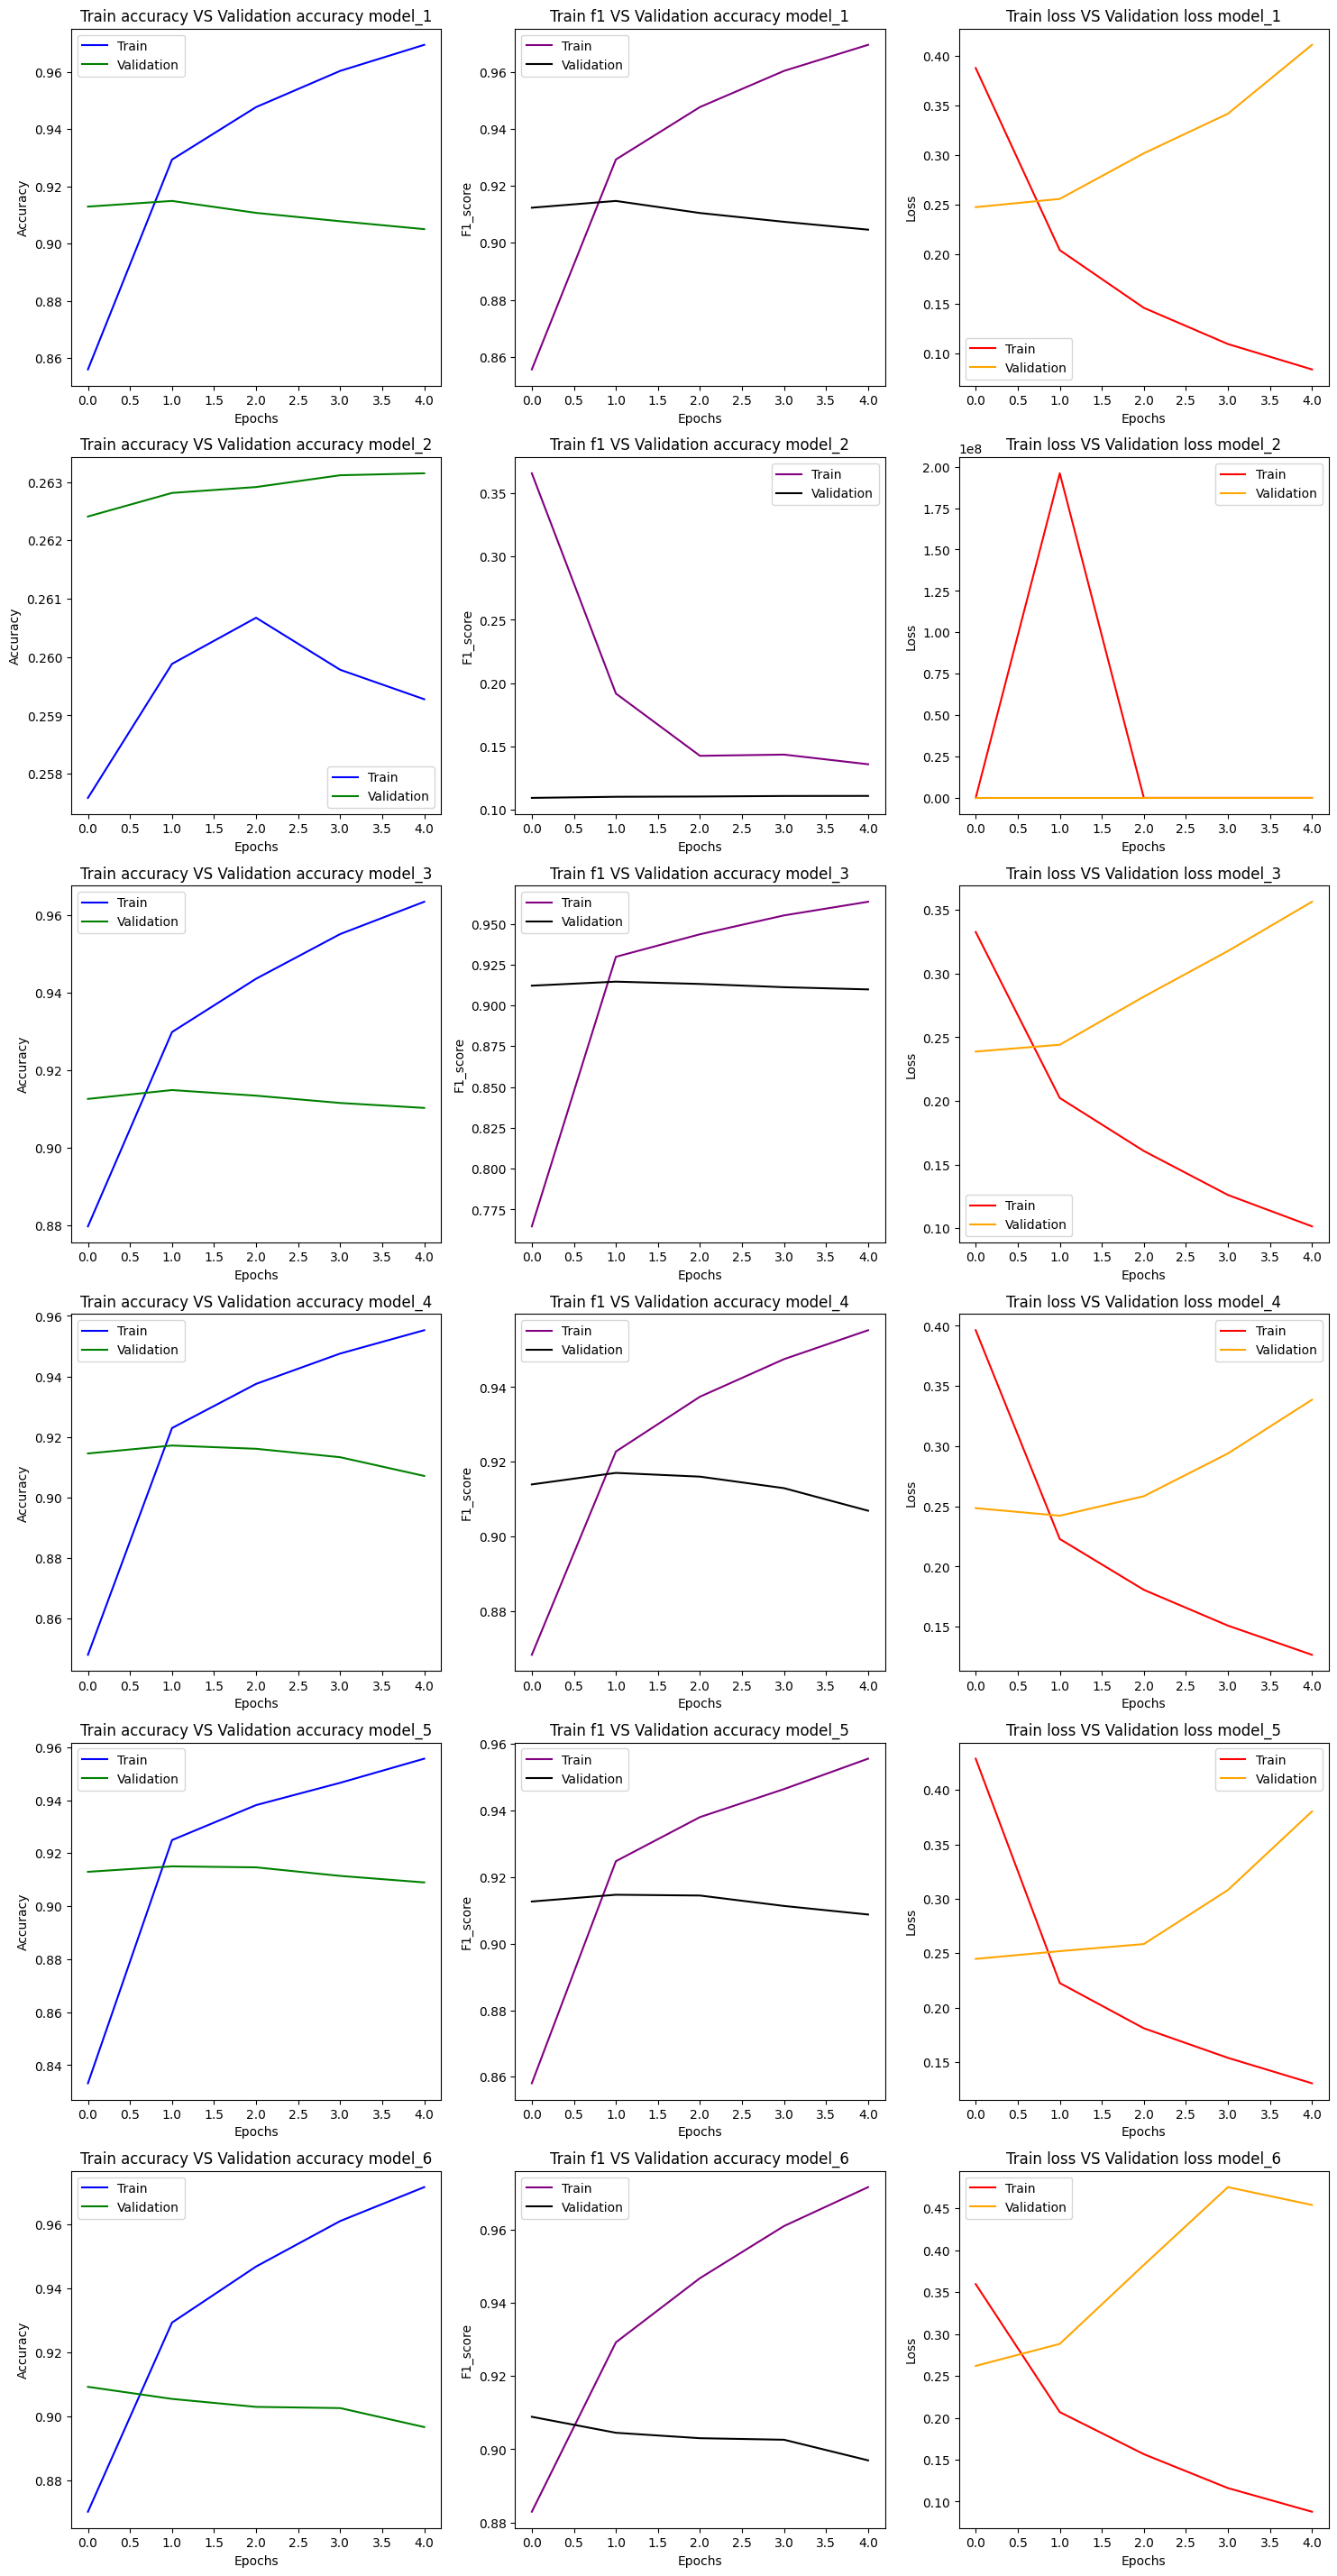

In [54]:
plt.figure(figsize=(18, 36))
plt.subplot(6, 3, 1)
plt.plot(history_1.history['accuracy'], c='blue', label='Train')
plt.plot(history_1.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_1')
plt.legend()
plt.subplot(6, 3, 2)
plt.plot(history_1.history['f1_score'], c='purple', label='Train')
plt.plot(history_1.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_1')
plt.legend()
plt.subplot(6, 3, 3)
plt.plot(history_1.history['loss'], c='red', label='Train')
plt.plot(history_1.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_1')
plt.legend()

plt.subplot(6, 3, 4)
plt.plot(history_2.history['accuracy'], c='blue', label='Train')
plt.plot(history_2.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_2')
plt.legend()
plt.subplot(6, 3, 5)
plt.plot(history_2.history['f1_score'], c='purple', label='Train')
plt.plot(history_2.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_2')
plt.legend()
plt.subplot(6, 3, 6)
plt.plot(history_2.history['loss'], c='red', label='Train')
plt.plot(history_2.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_2')
plt.legend()

plt.subplot(6, 3, 7)
plt.plot(history_3.history['accuracy'], c='blue', label='Train')
plt.plot(history_3.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_3')
plt.legend()
plt.subplot(6, 3, 8)
plt.plot(history_3.history['f1_score'], c='purple', label='Train')
plt.plot(history_3.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_3')
plt.legend()
plt.subplot(6, 3, 9)
plt.plot(history_3.history['loss'], c='red', label='Train')
plt.plot(history_3.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_3')
plt.legend()

plt.subplot(6, 3, 10)
plt.plot(history_4.history['accuracy'], c='blue', label='Train')
plt.plot(history_4.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_4')
plt.legend()
plt.subplot(6, 3, 11)
plt.plot(history_4.history['f1_score'], c='purple', label='Train')
plt.plot(history_4.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_4')
plt.legend()
plt.subplot(6, 3, 12)
plt.plot(history_4.history['loss'], c='red', label='Train')
plt.plot(history_4.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_4')
plt.legend()

plt.subplot(6, 3, 13)
plt.plot(history_5.history['accuracy'], c='blue', label='Train')
plt.plot(history_5.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_5')
plt.legend()
plt.subplot(6, 3, 14)
plt.plot(history_5.history['f1_score'], c='purple', label='Train')
plt.plot(history_5.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_5')
plt.legend()
plt.subplot(6, 3, 15)
plt.plot(history_5.history['loss'], c='red', label='Train')
plt.plot(history_5.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_5')
plt.legend()

plt.subplot(6, 3, 16)
plt.plot(history_6.history['accuracy'], c='blue', label='Train')
plt.plot(history_6.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_6')
plt.legend()
plt.subplot(6, 3, 17)
plt.plot(history_6.history['f1_score'], c='purple', label='Train')
plt.plot(history_6.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_6')
plt.legend()
plt.subplot(6, 3, 18)
plt.plot(history_6.history['loss'], c='red', label='Train')
plt.plot(history_6.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_6')
plt.legend();

In [55]:
class_indices = {
    'Business':0,
    'Politics':1,
    'Sport':2,
    'Tech':3
}
import json
with open('/kaggle/working/class_indices.json', 'w') as f:
    json.dump(class_indices, f)